In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

In [3]:
def read_trigger_efficiencies(root_file_path):
    with uproot.open(root_file_path) as root_file:
        efficiency_tree = root_file["trigger_efficiencies_tree"]
        
        m_values = efficiency_tree["M"].array()
        n_values = efficiency_tree["N"].array()
        efficiencies = efficiency_tree["Efficiency"].array()
        efficiency_errors = efficiency_tree["EfficiencyError"].array()
        energies = efficiency_tree["Energy"].array()
        sensor_sum = efficiency_tree["SumCounts"].array()
        thermal_electrons = efficiency_tree["ThermalElectrons"].array()
        
        return m_values, n_values, efficiencies, efficiency_errors, energies, sensor_sum, thermal_electrons

In [4]:
root_file_path = "/home/lane/Software/src/lumilar/system/analysis/data/trigger_efficiencies.root"
m_values, n_values, efficiencies, efficiency_errors, energies, sensor_sum, thermal_electrons = read_trigger_efficiencies(root_file_path)

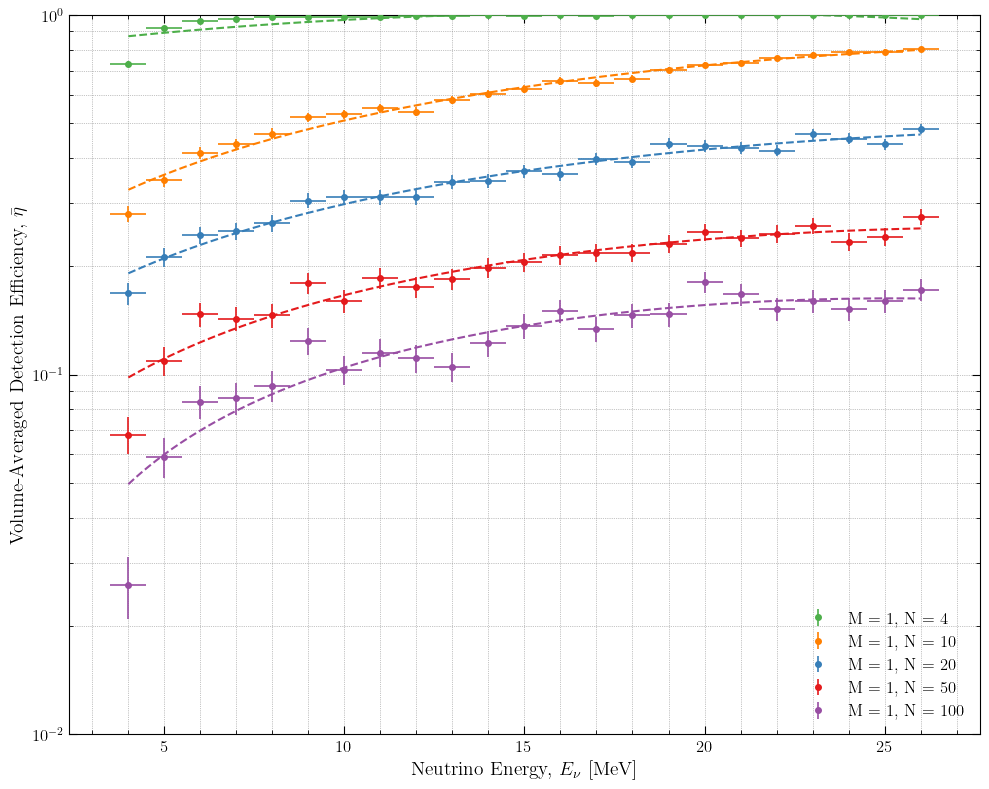

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

# Define the figure size
fig, ax = plt.subplots(figsize=(10, 8))

unique_combinations = set(zip(m_values, n_values))
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00', '#984EA3', '#A65628', '#F781BF', '#999999']

color_mapping = {}
for i, comb in enumerate(unique_combinations):
    color_mapping[comb] = colors[i % len(colors)]

polynomials_dict = {}

degree = 2
for comb in unique_combinations:
    x_data = []
    y_data = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            efficiency = efficiencies[i]
            if efficiency > 0.002:
                x_data.append(energies[i])
                y_data.append(efficiencies[i])

                color = color_mapping[comb]
                ax.errorbar(energies[i], efficiencies[i], yerr=efficiency_errors[i], xerr=1/2.0,
                            marker="o", markeredgewidth=1, capsize=0, markerfacecolor=color,
                            markeredgecolor=color, ms=4, color=color, lw=0.0, elinewidth=1.2,
                            zorder=10)

    if len(x_data) > degree:  # Ensuring enough data points for the polynomial fit
        coefficients = np.polyfit(x_data, y_data, degree)
        polynomial = np.poly1d(coefficients)
        
        # Storing the polynomial function in the dictionary
        polynomials_dict[comb] = polynomial
        
        x_range = np.linspace(min(x_data), max(x_data), 500)
        y_values = polynomial(x_range)
        ax.plot(x_range, y_values, '--', color=color, label=f"Fit for M = {comb[0]}, N = {comb[1]}")

sorted_combinations = sorted(unique_combinations, key=lambda comb: comb[1])

# Creating legend handles with crosses
handles = []
for comb in sorted_combinations:
    color = color_mapping[comb]
    line = ax.errorbar([], [], yerr=0.1, fmt='o', color=color, 
                       markeredgewidth=1, capsize=1.2, markerfacecolor=color,
                       markeredgecolor=color, ms=4, lw=0.0, elinewidth=1.2)
    handles.append(line)

# Adding the legend
legend = ax.legend(handles=handles, labels=[f'M = {comb[0]}, N = {comb[1]}' for comb in sorted_combinations], loc='lower right', fontsize=12, frameon=False)

ax.set_xlabel(r"Neutrino Energy, $E_\nu$ [MeV]", fontsize=14)
ax.set_ylabel(r"Volume-Averaged Detection Efficiency, $\bar{\eta}$", fontsize=14)

ax.set_ylim(1e-2, 1)

# Tick style
ax.tick_params(which='both', direction='in', top=True, right=True, length=6, labelsize=12)
ax.tick_params(which='minor', length=3)
ax.minorticks_on()

# Grid
ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.9)

ax.set_yscale('log')

plt.tight_layout()
plt.show()


In [6]:
m_value_example, n_value_example = 4, 10  # Replace with your desired m and n values
polynomial_func = polynomials_dict.get((m_value_example, n_value_example))
if polynomial_func:
    energy_value = 5  # Replace with your desired energy value
    efficiency_value = polynomial_func(energy_value)
    print(f"Efficiency at energy {energy_value} MeV: {efficiency_value}")
else:
    print(f"No polynomial function found for combination M = {m_value_example}, N = {n_value_example}")

No polynomial function found for combination M = 4, N = 10


In [7]:
from matplotlib.colors import LogNorm

def compute_smearing_matrix_mc(true_energies, reconstructed_energies, true_bin_edges, reco_bin_edges):
    # Step 1: Initialize smearing matrix with zeros
    smearing_matrix = np.zeros((len(reco_bin_edges)-1, len(true_bin_edges)-1))
    
    # Step 2: Loop over each event and fill the smearing matrix
    for true_e, reco_e in zip(true_energies, reconstructed_energies):
        for single_reco in reco_e:
            i = np.digitize(true_e, true_bin_edges) - 1  # bin index for true energy
            j = np.digitize(single_reco, reco_bin_edges) - 1  # bin index for each value in reconstructed energy

            smearing_matrix[j, i] += 1

    # Step 4: Normalization
    smearing_matrix /= smearing_matrix.sum(axis=0, keepdims=True)
    
    # Replace NaNs with zeros (occurs in columns with no entries)
    smearing_matrix = np.nan_to_num(smearing_matrix)
    
    return smearing_matrix


def add_fluctuations(value):
    binomial_val = np.random.binomial(value, 0.7)
    poisson_val = np.random.poisson(binomial_val)

    return poisson_val

/tmp/ipykernel_17975/3864565980.py:22: RuntimeWarning: invalid value encountered in true_divide
  smearing_matrix /= smearing_matrix.sum(axis=0, keepdims=True)


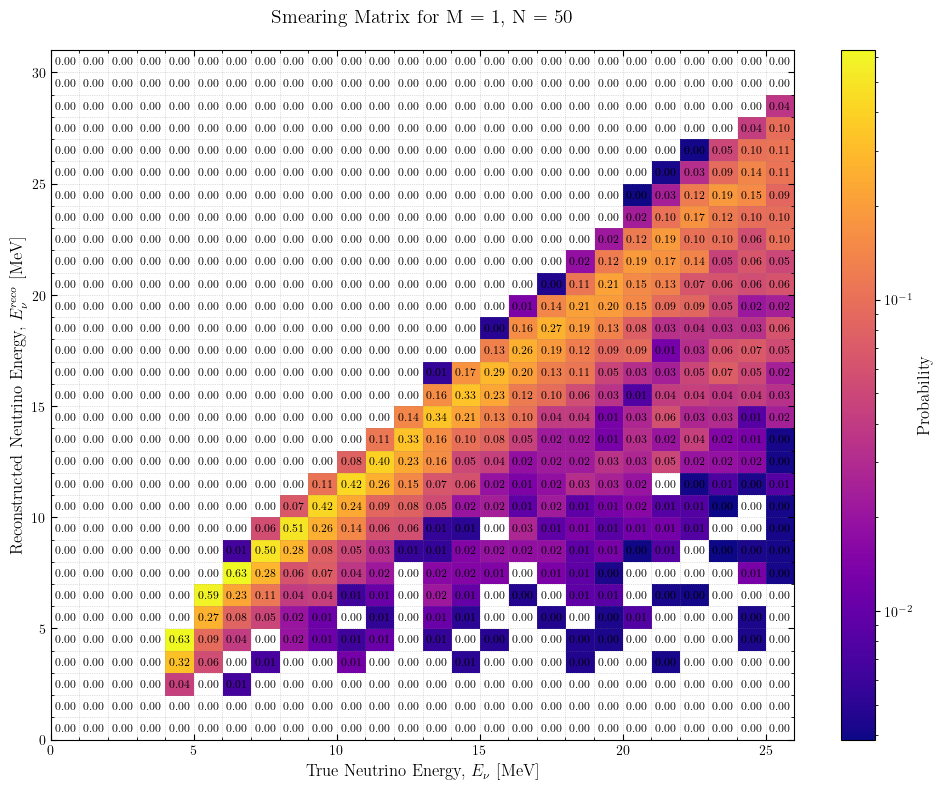

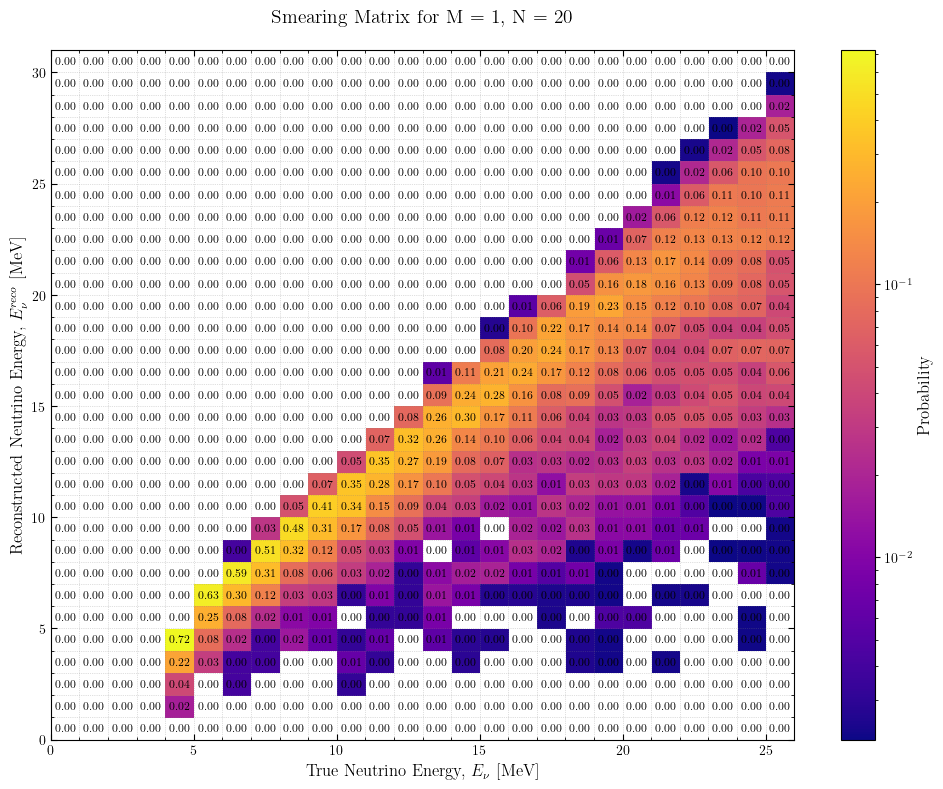

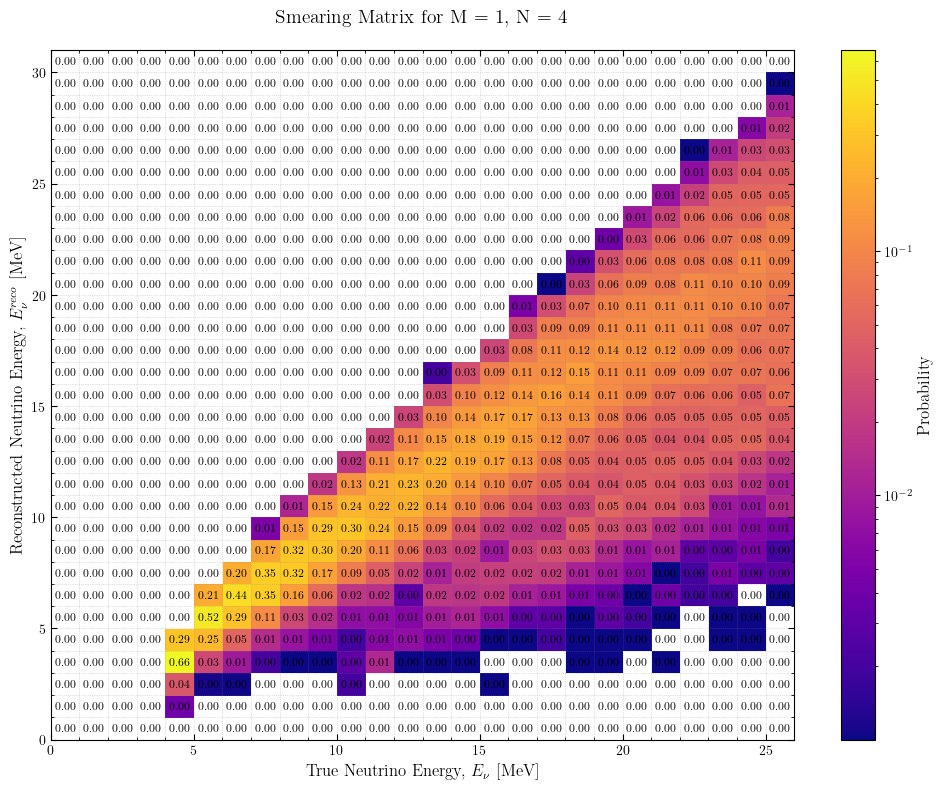

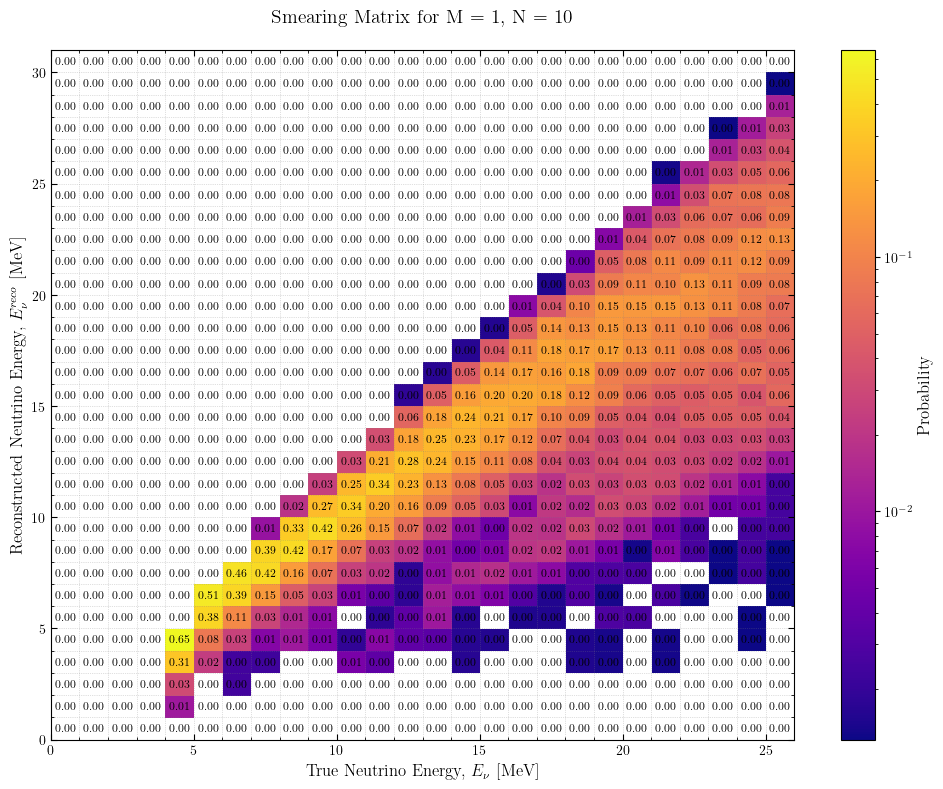

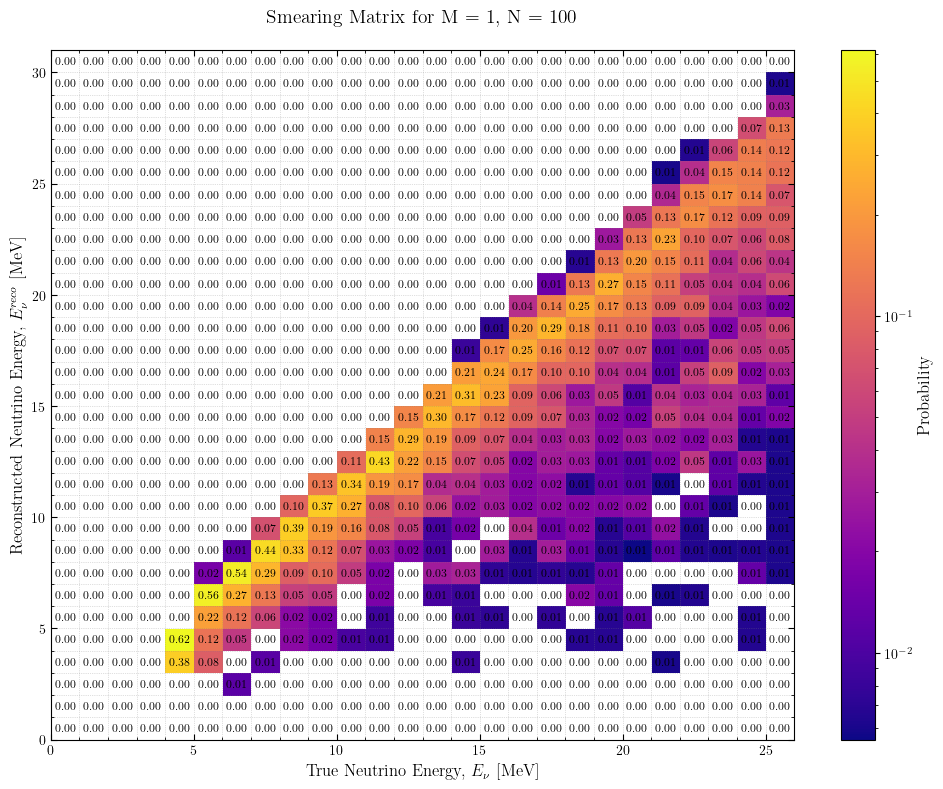

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

def compute_smearing_matrix(true_energies, reconstructed_energies, true_bin_edges, reco_bin_edges):
    # Initialize smearing matrix with zeros
    smearing_matrix = np.zeros((len(reco_bin_edges)-1, len(true_bin_edges)-1))
    
    # Loop over each event and fill the smearing matrix
    for true_e, reco_e in zip(true_energies, reconstructed_energies):
        i = np.digitize(true_e, true_bin_edges) - 1  # bin index for true energy
        j = np.digitize(reco_e, reco_bin_edges) - 1  # bin index for reconstructed energy

        # Check if the indices are within valid range
        if 0 <= i < smearing_matrix.shape[1] and 0 <= j < smearing_matrix.shape[0]:
            smearing_matrix[j, i] += 1

    # Normalization
    smearing_matrix /= smearing_matrix.sum(axis=0, keepdims=True)
    
    # Replace NaNs with zeros (occurs in columns with no entries)
    smearing_matrix = np.nan_to_num(smearing_matrix)
    
    return smearing_matrix

# Your main code
for comb in unique_combinations:
    x_data = []
    y_data_reco = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            x_data.extend([energies[i]] * len(thermal_electrons[i]))
            y_data_reco.extend((((add_fluctuations(thermal_electrons[i])/0.7) + 
                                 (np.random.poisson(sensor_sum[i])/0.004)) / 50000) + 1.504)
    
    true_bin_edges = np.linspace(0, 26, 27)  # Example bin edges from 0 to 50 MeV in 5 MeV bins
    reco_bin_edges = np.linspace(0, 31, 32)

    K = compute_smearing_matrix(x_data, y_data_reco, true_bin_edges, reco_bin_edges)

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(K, aspect='auto', cmap=sns.color_palette("plasma", as_cmap=True), origin='lower', 
                    extent=[true_bin_edges[0], true_bin_edges[-1], reco_bin_edges[0], reco_bin_edges[-1]], norm=LogNorm())
    
    true_centers = (true_bin_edges[:-1] + true_bin_edges[1:]) / 2
    reco_centers = (reco_bin_edges[:-1] + reco_bin_edges[1:]) / 2

    for i, rc in enumerate(reco_centers):
        for j, tc in enumerate(true_centers):
            text = ax.text(tc, rc, f"{K[i, j]:.2f}", ha="center", va="center", 
                           color="black", fontsize=8)
    
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label(r'Probability', size=12)
    cbar.ax.tick_params(labelsize=10)
    
    ax.set_xlabel(r"True Neutrino Energy, $E_\nu$ [MeV]", fontsize=12)
    ax.set_ylabel(r"Reconstructed Neutrino Energy, $E_\nu^{reco}$ [MeV]", fontsize=12)
    ax.set_title(f"Smearing Matrix for M = {comb[0]}, N = {comb[1]}", pad=20, fontsize=14)
    
    ax.tick_params(which='both', direction='in', top=True, right=True, length=4)
    ax.tick_params(which='minor', length=2)
    ax.minorticks_on()

    ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_17975/1826368995.py:23: RuntimeWarning: invalid value encountered in true_divide
  smearing_matrix /= smearing_matrix.sum(axis=0, keepdims=True)


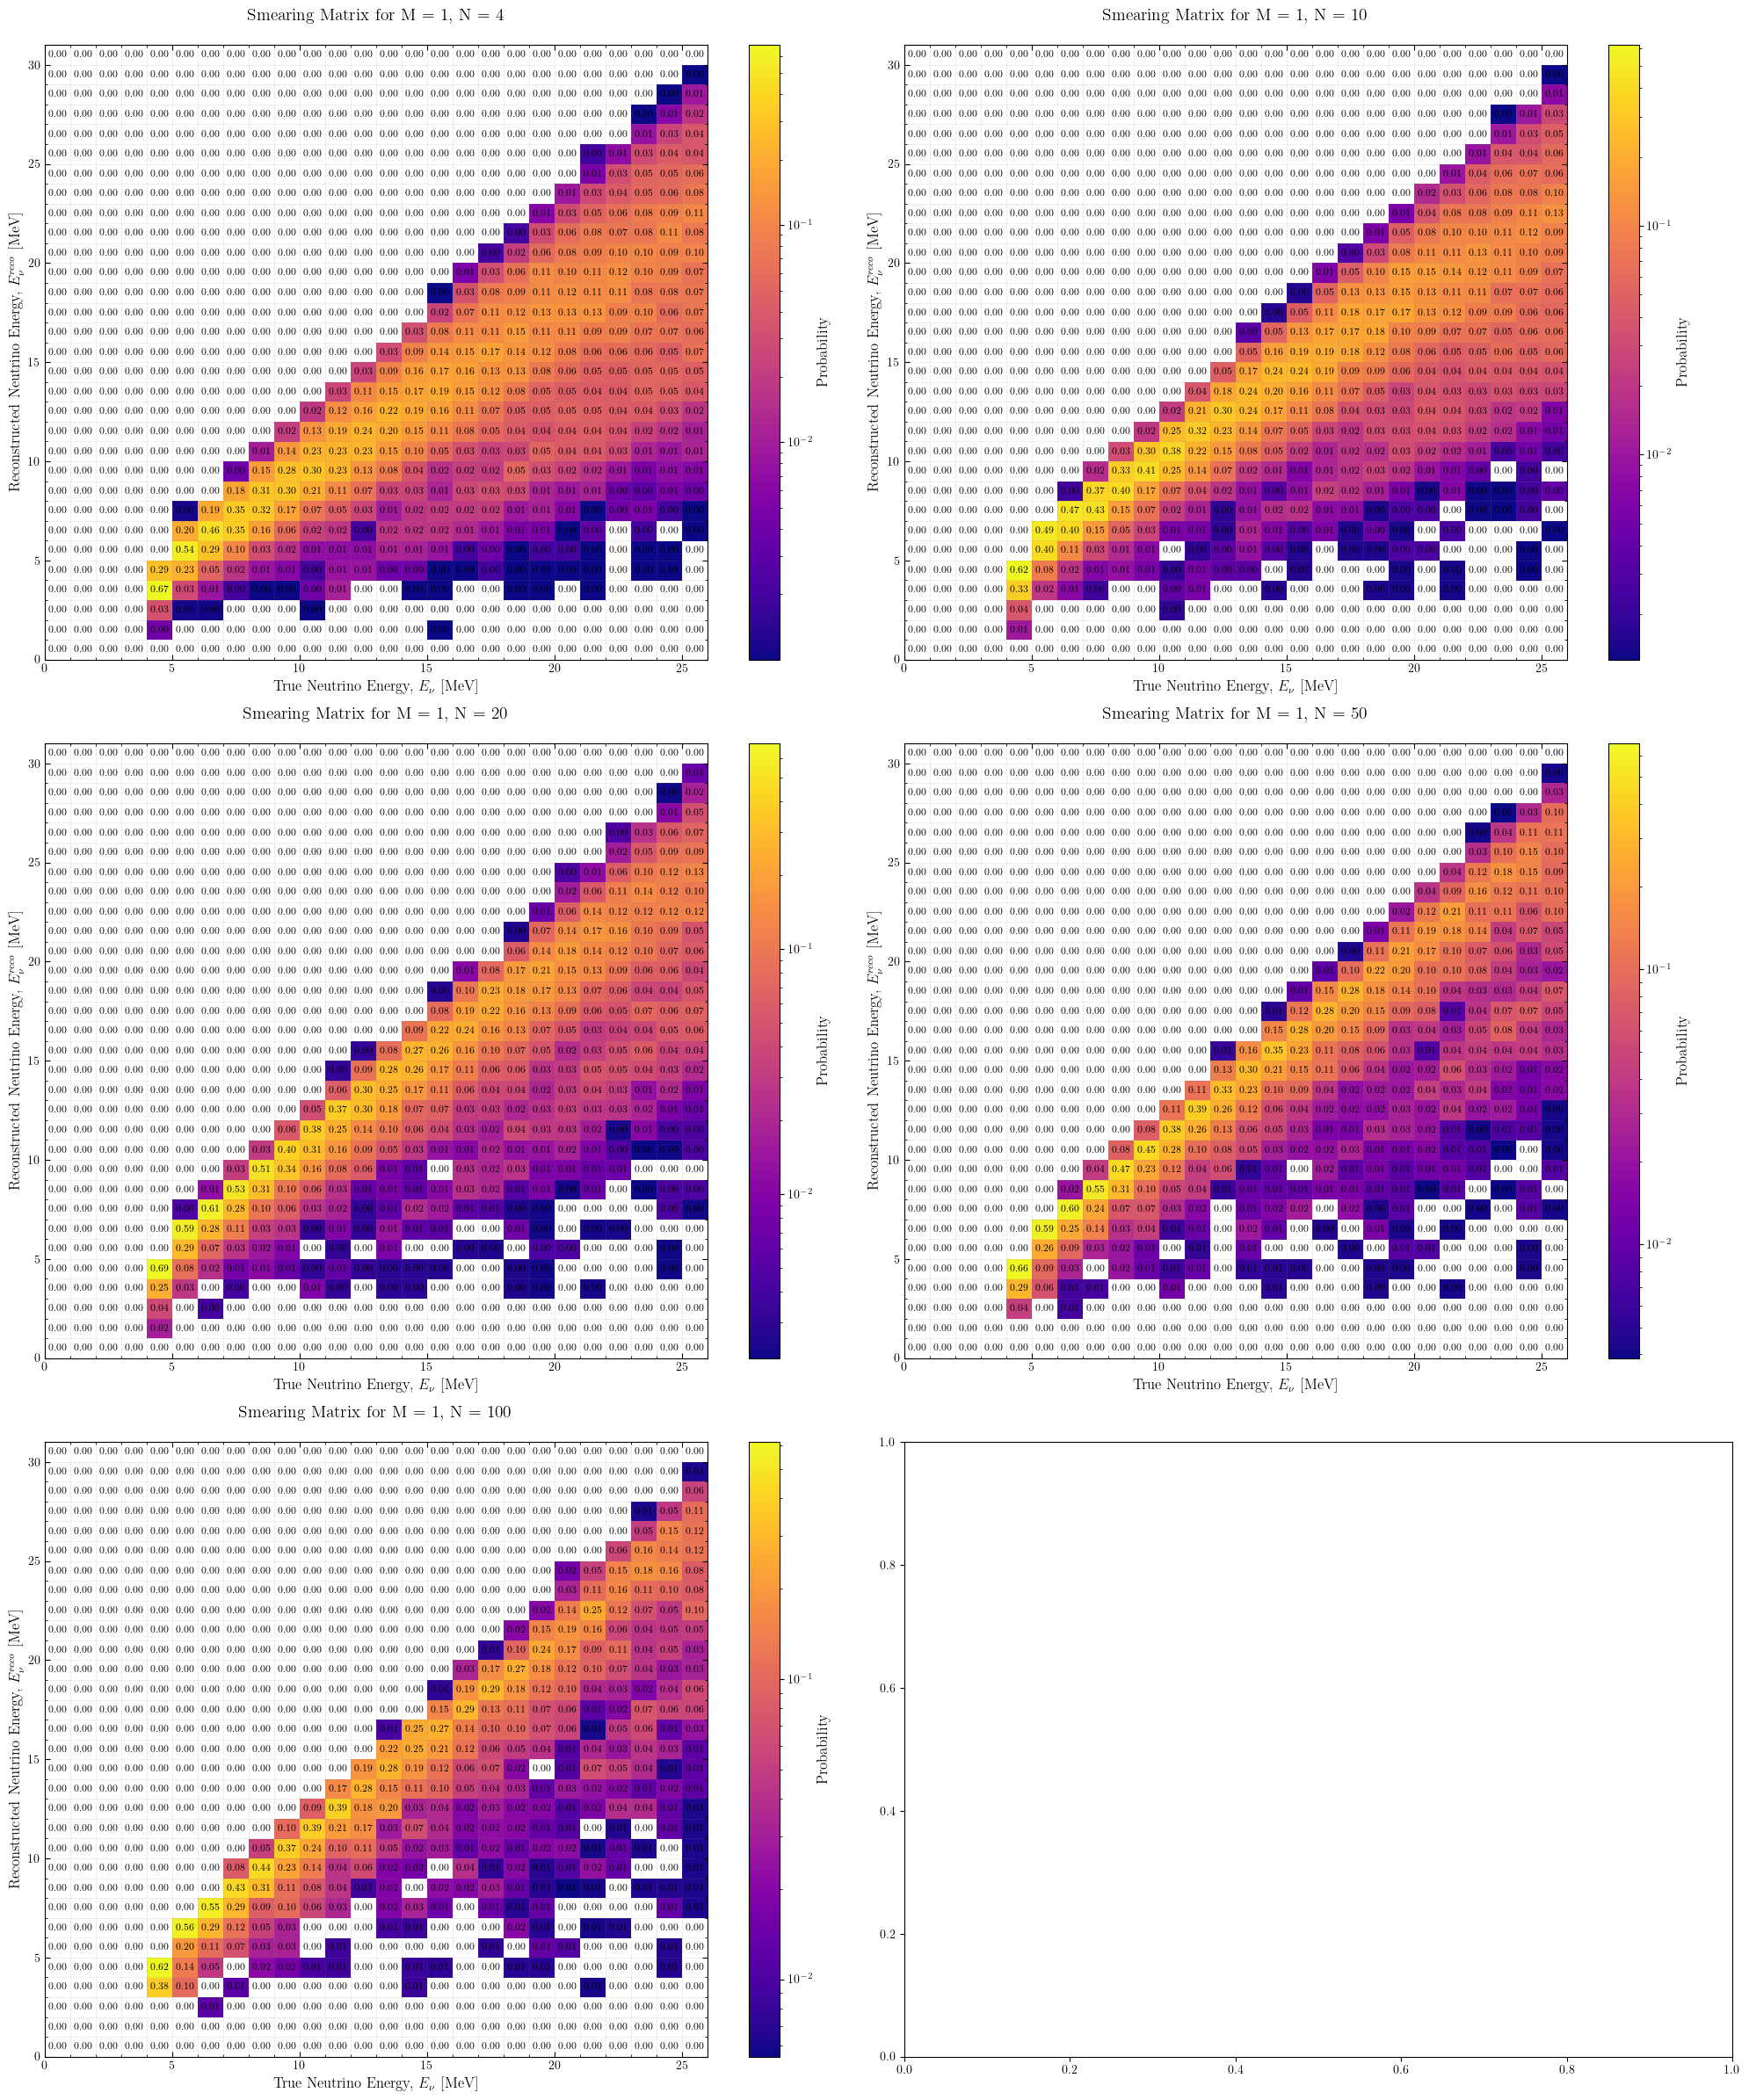

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
import seaborn as sns

unique_combinations = sorted(unique_combinations, key=lambda x: (x[1], x[0]))


mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

def compute_smearing_matrix(true_energies, reconstructed_energies, true_bin_edges, reco_bin_edges):
    smearing_matrix = np.zeros((len(reco_bin_edges)-1, len(true_bin_edges)-1))
    
    for true_e, reco_e in zip(true_energies, reconstructed_energies):
        i = np.digitize(true_e, true_bin_edges) - 1
        j = np.digitize(reco_e, reco_bin_edges) - 1

        if 0 <= i < smearing_matrix.shape[1] and 0 <= j < smearing_matrix.shape[0]:
            smearing_matrix[j, i] += 1

    smearing_matrix /= smearing_matrix.sum(axis=0, keepdims=True)
    smearing_matrix = np.nan_to_num(smearing_matrix)
    
    return smearing_matrix

# Assuming unique_combinations, energies, m_values, n_values, thermal_electrons, sensor_sum, and add_fluctuations are already defined...

ncols = 2
nrows = int(np.ceil(len(unique_combinations) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 8 * nrows))

for index, comb in enumerate(unique_combinations):
    ax = axes[index] if nrows == 1 or ncols == 1 else axes[index // ncols, index % ncols]
    
    x_data = []
    y_data_reco = []
    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            x_data.extend([energies[i]] * len(thermal_electrons[i]))
            y_data_reco.extend((((add_fluctuations(thermal_electrons[i])/0.7) + 
                                 (np.random.poisson(sensor_sum[i])/0.004)) / 50000) + 1.504)
    
    true_bin_edges = np.linspace(0, 26, 27)
    reco_bin_edges = np.linspace(0, 31, 32)

    K = compute_smearing_matrix(x_data, y_data_reco, true_bin_edges, reco_bin_edges)

    cax = ax.imshow(K, aspect='auto', cmap=sns.color_palette("plasma", as_cmap=True), origin='lower', 
                    extent=[true_bin_edges[0], true_bin_edges[-1], reco_bin_edges[0], reco_bin_edges[-1]], norm=LogNorm())
    
    true_centers = (true_bin_edges[:-1] + true_bin_edges[1:]) / 2
    reco_centers = (reco_bin_edges[:-1] + reco_bin_edges[1:]) / 2

    for i, rc in enumerate(reco_centers):
        for j, tc in enumerate(true_centers):
            text = ax.text(tc, rc, f"{K[i, j]:.2f}", ha="center", va="center", 
                           color="black", fontsize=8)
    
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label(r'Probability', size=12)
    cbar.ax.tick_params(labelsize=10)
    
    ax.set_xlabel(r"True Neutrino Energy, $E_\nu$ [MeV]", fontsize=12)
    ax.set_ylabel(r"Reconstructed Neutrino Energy, $E_\nu^{reco}$ [MeV]", fontsize=12)
    ax.set_title(f"Smearing Matrix for M = {comb[0]}, N = {comb[1]}", pad=20, fontsize=14)
    
    ax.tick_params(which='both', direction='in', top=True, right=True, length=4)
    ax.tick_params(which='minor', length=2)
    ax.minorticks_on()

    ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

plt.tight_layout()
plt.show()
